In [1]:
# you need to install hmvec
# instructions here: https://github.com/simonsobs/hmvec

In [6]:
import os,sys
print(sys.path)
sys.path.append('/home/dpirvu/')
sys.path.append('../')
sys.path.append('./hmvec-master/')
import hmvec as hm


['/home/dpirvu/axion', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhoton/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '../', './hmvec-master/', '/home/dpirvu/']


In [7]:
import numpy as np
import scipy as scp
from scipy.special import eval_legendre, legendre, spherical_jn
import itertools
import time
from scipy import interpolate
from itertools import cycle
from math import atan2,degrees,lgamma 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp2d,interp1d
import scipy.interpolate as si
import random


In [8]:
# you can ignore this one box

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e'%x))
fmt = mticker.FuncFormatter(g)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

plt.rcParams.update({'backend' : 'Qt5Agg'})
plt.rcParams.update({'text.usetex' : True})

plt.rcParams.update({'font.size' : 11.0})
plt.rcParams.update({'axes.titlesize' : 14.0})  # Font size of title
plt.rcParams.update({'axes.titlepad'  : 10.0})
plt.rcParams.update({'axes.labelsize' : 14.0})  # Axes label sizes
plt.rcParams.update({'axes.labelpad'  : 10.0})
plt.rcParams.update({'xtick.labelsize'  : 14.0})
plt.rcParams.update({'ytick.labelsize'  : 14.0})
plt.rcParams.update({'xtick.labelsize'  : 10.0})
plt.rcParams.update({'ytick.labelsize'  : 10.0})

plt.rcParams.update({'axes.spines.left'  : True})
plt.rcParams.update({'axes.spines.right'  : True})
plt.rcParams.update({'axes.spines.top'  : True})
plt.rcParams.update({'axes.spines.bottom'  : True})
plt.rcParams.update({'savefig.format'     : 'pdf'})
plt.rcParams.update({'savefig.bbox'       : 'tight'})
plt.rcParams.update({'savefig.pad_inches' : 0.1})
plt.rcParams.update({'pdf.compression' : 6})

def plot_dmdz(ms, zs, func, count=10, title='No Title'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[:count//count] else None), alpha=1-c1/count, color='k')
            c1 += 1
        elif mm in ms[-count:]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[-count//count:] else None), alpha=c2/count, color='g')
            c2 += 1
    for zi, zz in enumerate(zs):
        if zz in zs[:count]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[:count//count] else None), alpha=1-g1/count, color='r')
            g1 += 1
        elif zz in zs[-count:]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[-count//count:] else None), alpha=g2/count, color='b')
            g2 += 1

    ax[0].set_xlabel(r'$z$')
    ax[1].set_xlabel(r'$m$')
    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(title)
        axx.legend(loc='best'); axx.grid()
    return ax

def plot_ucosth(ms, zs, angs, ucosth, prob, title, count=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    nMs, nZs = len(ms), len(zs)
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g1/count, color='g')
            g1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            g1 += 1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g1/count, color='g')
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(r'$u(\cos(\theta)) \times Prob$')
        axx.set_xlabel(r'$\theta$')
        axx.legend(loc='best'); axx.grid()
    return ax


In [5]:
# Functions to compute the useful stuff

get_volume_conv = lambda chis, Hz: chis**2. / Hz

def get_rcross_per_halo(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, name='battagliaAGN'):
    """ Compute crossing radius of each halo
    i.e. radius where plasma mass^2 = dark photon mass^2
    Find the index of the radius array where plasmon mass^2 = dark photon mass^2 """

    m200critz, r200critz = get_200critz(zs, ms, cs, rhocritz, deltav)
    gas_profile = get_gas_profile(rs[None,None,:], zs[:,None,None], m200critz[...,None], 
                                  r200critz[...,None], rhocritz[:,None,None])
    
    # to get from rho to MA multiply by conv
    return rs[np.argmin(np.abs(conv*gas_profile - MA**2.), axis=-1)]

def R_from_M(M,rho,delta):
    ''' Gives you halo radius from mass and overdensity'''
    return (3.*M/4./np.pi/delta/rho)**(1./3.) 

def get_200critz(zs, ms, cs, rhocritz, deltav):
    delta_rhos1 = deltav*rhocritz
    delta_rhos2 = 200.*rhocritz
    m200critz = hm.mdelta_from_mdelta(ms, cs, delta_rhos1, delta_rhos2)
    r200critz = R_from_M(m200critz, rhocritz[:,None], delta=200.)
    return m200critz, r200critz

def get_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    rho = rhocritz * rho0
    x = rs/r200/xc
    expo = -(beta+gamma)/alpha     # gamma sign must be opposite from Battaglia/ACT paper; typo
    return rho * (x**gamma) * ((1.+x**alpha)**expo)

def battagliaAGN(m200, zs):
    # power law fits:
    rho0  = 4000. * (m200/1e14)**0.29    * (1.+zs)**(-0.66)
    alpha = 0.88  * (m200/1e14)**(-0.03) * (1.+zs)**0.19
    beta  = 3.83  * (m200/1e14)**0.04    * (1.+zs)**(-0.025)
        
    gamma = -0.2
    xc    = 0.5
    return rho0, alpha, beta, gamma, xc

def conv_prob(zs, rvir, MA, rcross):
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang  = 2.*np.heaviside(rvir - rcross, 0.5)
    return mpcEVinv * rcross * uang * omgz / MA**2.

def old_conv_prob(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    return mpcEVinv * uang * omgz / dmdr

def get_deriv_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    x = rs / r200 / xc
    P = rhocritz * rho0
    expo = -(alpha+beta+gamma)/alpha
    drhodr = P * (x**gamma) * (1. + x**alpha)**expo * (gamma - x**alpha * beta) / rs

    if hasattr(rs, "__len__"): drhodr[rs==0.] = 0.
    elif rs==0: drhodr = 0.
    return drhodr

def get_u00(angs, ucosth):
    # angular function u(theta) projected into multipoles
    cos_angs = np.cos(angs)
    Pell     = eval_legendre(0, cos_angs)
    integr   = Pell * np.sin(angs) * ucosth
    uL0      = 2.*np.pi * np.trapz(integr, angs, axis=0)
    return uL0 * (4.*np.pi)**(-0.5)

def get_avtau(zs, ms, nzm, dvol, prob00):
    # Average optical depth per redshift bin
    dtaudz = np.trapz(nzm * prob00, ms, axis=-1) * dvol * 4*np.pi
    avtau  = np.trapz(dtaudz, zs, axis=0)
    return avtau, dtaudz

def get_halo_skyprofile(zs, chis, rcross):
    # get theta coordinate bounds within each halo
    rchis = chis*aa(zs)
    fract = (rcross/rchis[:,None])[None,...]

    # choose how many points to sample:
    nsamp = 71
    listincr = 1. - np.geomspace(1e-3, 1., nsamp)
    listincr = np.asarray([1.] + listincr.tolist())[::-1]
    angs = listincr[:,None,None] * fract

    ucosth = (1.-(angs/fract)**2.)**(-0.5)
    ucosth[angs == fract] = 0.
    return ucosth, angs



In [ ]:
############# Define constants ################
# From hmvec:
# proper radius r is always in Mpc
# comoving momentum k is always in Mpc-1
# All masses m are in Msolar
# rho densities are in Msolar/Mpc^3
# No h units anywhere

TFIRAS   = 2.725
TCMB     = 2.725*1e6
cmMpc    = 3.2407792896e-25    # Mpc/cm            # how many Mpc in a cm
eVinvCm  = 1.97*1e-5  #1.2398419e-4        # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

msun   = 1.9891e30     # kg               # Sun mass
mprot  = 1.67262e-27   # kg               # Proton mass
m2eV   = 1.4e-21       # eV^2             # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2  = 0.02225                 # Physical baryon density parameter Ωb h2
omch2  = 0.1198                  # Physical dark matter density parameter Ωc h2
conv   = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3.

thomson = 0.6652*1e-24
conv2 = thomson*(ombh2/omch2)*(msun/mprot)*(cmMpc)**2.

ev2Joule = lambda ev: 1.602176565*1e-19*ev
K2eV = lambda K: 8.61732814974493*1e-5*K
cligth = 299792458.0 #m/s
hplanck = 6.62607015*1e-34 # m2 kg / s
kboltzmann = 1.380649*1e-23 # m2 kg s-2 K-1
gauss2evsq = lambda gauss: 1.95e-2 * gauss
frq = lambda nu: 100. * nu * cligth

BBf = lambda frq: 1e26/1e6*(2.*frq**3.*hplanck)/cligth**2. / (np.exp(hplanck*frq/kboltzmann/TFIRAS) - 1.)
BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)

aa = lambda z: 1./(1.+z)

arcmin2rad = lambda arcm: arcm/60. * np.pi/180.
ghztoev    = lambda GHz: 4.13566553853809E-06 * GHz


In [5]:
# Select axion mass in eV
MA = 1e-12

# choose redshift range:
zMin, zMax = 0.005, 6.

# rmin and rmax are the radial limits to scan over in each halo
# need to make sure crossing radius is within these limits
rMin, rMax = 1e-6, 5e1


In [6]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nMs = 100
nZs = 50
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = np.geomspace(1e11, 1e17, nMs)      # all masses
zs  = np.linspace(zMin, zMax, nZs)       # all redshifts
rs  = np.linspace(rMin, rMax, 100000)    # halo radial coords
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [7]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)


In [8]:
dvols  = get_volume_conv(chis, Hz)

# crossing radius in each halo:
rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)


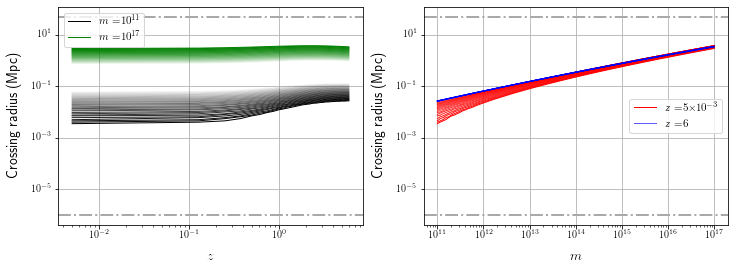

In [143]:
ax1 = plot_dmdz(ms, zs, rcross, count=30, title='Crossing radius (Mpc)')
ax1[0].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[0].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
plt.show()


In [9]:
ucosth, angs = get_halo_skyprofile(zs, chis, rcross)


/tmp/ipykernel_59588/1893030299.py:90: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)


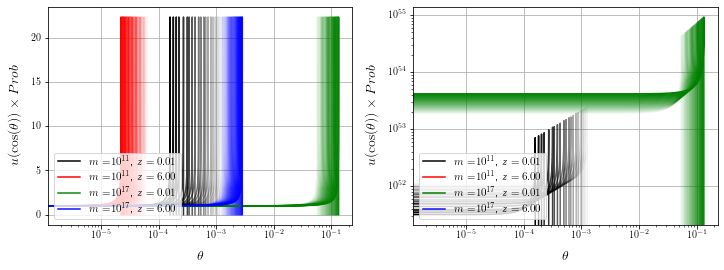

In [149]:
ax = plot_ucosth(ms, zs, angs, ucosth, prob, count=20, title=r'Angular profile $u(\theta)$')
ax[0].set_yscale('linear')
#[aax.set_xscale('linear') for aax in ax]
[aax.legend(loc=3) for aax in ax]; plt.show()


In [121]:
# Computes probability taking into account inverse of the derivative to trajectory
# See eq. 2.11(A) of https://arxiv.org/pdf/2307.15124.pdf
# It needs a check!!!
# TODO: double checked the expression with Junwu

prob = old_conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)

# Computes probability with r_cross
# This one is fine works fine

#prob = conv_prob(zs, rvirs, MA, rcross)


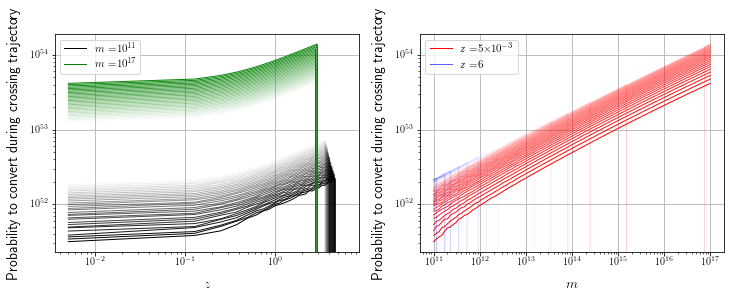

In [145]:
ax = plot_dmdz(ms, zs, prob, count=30, title='Probability to convert during crossing trajectory')
plt.show()


In [123]:
u00 = get_u00(angs, ucosth)
prob00 = prob * u00

avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)


In [124]:
# photon frequency:
baseline = ghztoev(30) # plug in GHz to get value in eV

# magetic field amp 
bfield = gauss2evsq(1e-7) # plug in G to get value in eV^2

units = baseline * bfield**2.
print(units)


4.717760463087327e-22


In [150]:
print('for axion mass [eV]:', MA, 'monopole magnitude:', avtau)

for axion mass [eV]: 1e-12 monopole magnitude: 4.894759298280069e+53


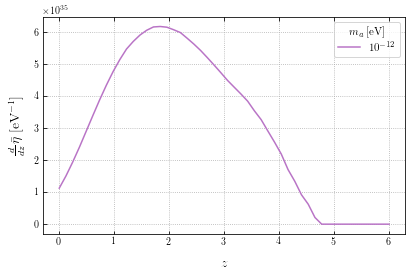

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))

lab2 = r'{}'.format(fmt(MA))

ax.plot(zs, dtaudz*units/baseline, ls='-', label=lab2)

ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV^{-1}}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()
